# Random Forest Feature Imputation

This notebook uses Random forest to impute missing values for all features. The procedure is described as follows
- record missing locations
- Initialize all missing values using mean and mode
- Iterating features Y from the least to the most missing rates, use the rest of the features X to predict Y on the observed values (i.e. $Y[idx_{Yobs}] \sim X[idx_{Yobs},]$), then predict $Y[idx_{Ymis}]$ using $X[idx_{Ymis},]$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from importlib import reload
import seaborn as sns
import os, sys
from tqdm import tqdm

sys.path.append(os.path.join("../", "utils"))
import load_data
reload(load_data)
uds_dict, mri_dict = load_data.load_feature_map()

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import LabelEncoder

In [2]:
def clip_df(df, col_limit_dict=None):
    if col_limit_dict is not None:
        for i, c in enumerate(list(df.columns)):
            df.loc[:,c] = np.clip(df.loc[:,c], col_limit_dict[c][0], col_limit_dict[c][1])
    return df

def missing_rf(df_temp, column_fill_order, nas_idx_map, cat_var, num_var, n_estimators=100, max_depth=None):
    mse, rf_metrics = {}, {}
    for c in tqdm(column_fill_order):
        rest_columns = list(set(df_temp.columns) - set([c]))
        X, X_predict = df_temp.loc[~df_temp.index.isin(nas_idx_map[c]), rest_columns], df_temp.loc[nas_idx_map[c], rest_columns]
        y = df_temp.loc[~df_temp.index.isin(nas_idx_map[c]), c]
        
        rf_class = RandomForestRegressor if c in num_var else RandomForestClassifier
        rf = rf_class(max_depth=max_depth, n_estimators=n_estimators, random_state=48, n_jobs=5)  
        rf.fit(X, y)
        df_temp.loc[nas_idx_map[c], c] = rf.predict(X_predict)
        rf_metrics[c] = mean_squared_error(y, rf.predict(X)) if c in num_var else accuracy_score(y, rf.predict(X)) * 100
    mse = {c: rf_metrics[c] for c in column_fill_order if c in num_var}
    acc = {c: rf_metrics[c] for c in column_fill_order if c in cat_var} 
    largest_mse = sorted(mse.items(), key=lambda x: x[1], reverse=True)[0] 
    if len(acc) == 0:
        print("Mean MSE: {:.3f} (Largest-{}: {:.3f})".format(np.mean(list(mse.values())), largest_mse[0], largest_mse[1]))
    else:
        smallest_acc = sorted(acc.items(), key=lambda x: x[1])[0] 
        print("Mean MSE: {:.3f} (Largest-{}: {:.3f})\t Mean ACC: {:.3f} (Smallest-{}: {:.3f}) ".format(
            np.mean(list(mse.values())), largest_mse[0], largest_mse[1], 
            np.mean(list(acc.values())), smallest_acc[0], smallest_acc[1]))
    return df_temp

def impute_missing_RF(df, n_estimators=50, max_depth=None, stop=5, small=1e-3, column_limit_dict=None):
    df_temp = df.copy()
    df_temp = clip_df(df, column_limit_dict)
    label_encoder = {}
    # First filling the most least missing columns
    nas = df_temp.isna()
    column_fill_order = list(nas.sum()[nas.sum()>0].sort_values().to_dict().keys())
    nas_idx_map = {c: nas[nas[c]==True].index for c in nas.columns}

    # Prepare the initial mean/mode filled df_temp
    cat_var = df.nunique()[df.nunique().values < 10].index.values
    for c in cat_var:
        df_temp[c] = df_temp[c].fillna(value = df_temp[c].mode().values[-1])
        encoder = LabelEncoder()
        df_temp[c] = encoder.fit_transform(df_temp[c])
        label_encoder[c] = encoder
    num_var = np.array(list(set(df.columns) - set(cat_var)))
    for c in num_var:
        df_temp[c] = df_temp[c].fillna(value = df_temp[c].mean())        
    # Start imputing missing using RF
    iteration=0
    imputed_values = {c: np.array([0 for i in range(v)]) for c, v in nas.sum()[nas.sum()>0].sort_values().to_dict().items()}
    new_imputed_values = {c: df_temp.loc[nas_idx_map[c], c].values for c in column_fill_order}
    error = [np.mean((imputed_values[c] - new_imputed_values[c])**2) for c in imputed_values]
    while max(error) > small and iteration < stop:
        print("Iteration {}: {:.3f} (on {})".format(iteration, max(error), list(nas_idx_map.keys())[np.argmax(error)]))
        imputed_values = new_imputed_values
        df_temp = missing_rf(df_temp, column_fill_order, nas_idx_map, cat_var, num_var, n_estimators, max_depth)
        new_imputed_values = {c: df_temp.loc[nas_idx_map[c], c].values for c in column_fill_order}
        error = [np.mean((imputed_values[c] - new_imputed_values[c])**2) for c in imputed_values]
        iteration += 1
    print("Finished-Iteration {}: {:.3f} (on {})".format(iteration, max(error), column_fill_order[np.argmax(error)]))
    if iteration == stop:
        print("Warning: Does not converge")
    df_temp = clip_df(df, column_limit_dict)
    for c in cat_var:
        df_temp[c] = label_encoder[c].inverse_transform(df_temp[c])
    return df_temp

In [3]:
def examine_missing_imputation(df, df_imputed, num, nrow, ncol, figsize):
    var = np.random.choice(df.isna().sum()[df.isna().sum()>0].index.values, num, replace=False)
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize)
    for i, v in enumerate(var):
        ax = axes[i] if nrow == 1 or ncol == 1 else axes[i//nrow, i%ncol]
        ax.hist(df[v], bins=100, alpha=0.5, label='Original')
        ax.hist(df_imputed.loc[df[v].isna(), v], bins=100, alpha=0.5, label='Imputed')
        ax.legend()
        ax.set_title("{} (missing-{:.3f}%)".format(v, df[v].isna().sum()/df.shape[0]*100), fontsize = 16)
    plt.tight_layout()
    plt.show()

## Impute UDS

In [4]:
def drop_missing(df, row_thres=0.5, col_thres=0.5):
    df = df.loc[df.isna().mean(axis=1)<row_thres, df.isna().mean(axis=0)<col_thres]
    return df

uds = load_data.load_uds()
print("Original uds shape:  ", uds.shape)

print("UDS features need to have missing rate below 85%")
uds = drop_missing(uds, row_thres=1, col_thres=0.8)
print("After dropping features:  ", uds.shape)
print("Num of Features needs to be imputed:  ", (uds.isna().sum()>0).sum())

Original uds shape:   (45100, 94)
UDS features need to have missing rate below 85%
After dropping features:   (45100, 87)
Num of Features needs to be imputed:   71


In [5]:
uds_to_fill = uds.drop(['NACCID', 'NACCADC', 'NACCVNUM', 'datetime', 'SEX', 'NACCAGE','EDUC', 'NACCUDSD', 'NACCALZP'], axis=1)
uds_imputed = impute_missing_RF(uds_to_fill, small=1e-3)

Iteration 0: 17503.104 (on DEPDSEV)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [01:38<00:00,  1.41s/it]


Mean MSE: 13.458 (Largest-TRAILB: 214.114)	 Mean ACC: 99.975 (Smallest-APP: 99.892) 
Iteration 1: 17979.212 (on DEPDSEV)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [01:54<00:00,  1.64s/it]


Mean MSE: 6.193 (Largest-TRAILB: 92.593)	 Mean ACC: 99.979 (Smallest-APP: 99.944) 
Iteration 2: 1454.574 (on DEPDSEV)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [01:51<00:00,  1.60s/it]


Mean MSE: 6.820 (Largest-TRAILB: 104.179)	 Mean ACC: 99.979 (Smallest-APP: 99.953) 
Iteration 3: 254.984 (on DEPDSEV)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [01:48<00:00,  1.56s/it]


Mean MSE: 6.438 (Largest-TRAILB: 97.862)	 Mean ACC: 99.978 (Smallest-IRR: 99.941) 
Iteration 4: 197.361 (on DEPDSEV)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [01:44<00:00,  1.50s/it]

Mean MSE: 6.268 (Largest-TRAILB: 95.147)	 Mean ACC: 99.978 (Smallest-IRR: 99.941) 
Finished-Iteration 5: 220.050 (on TRAILB)


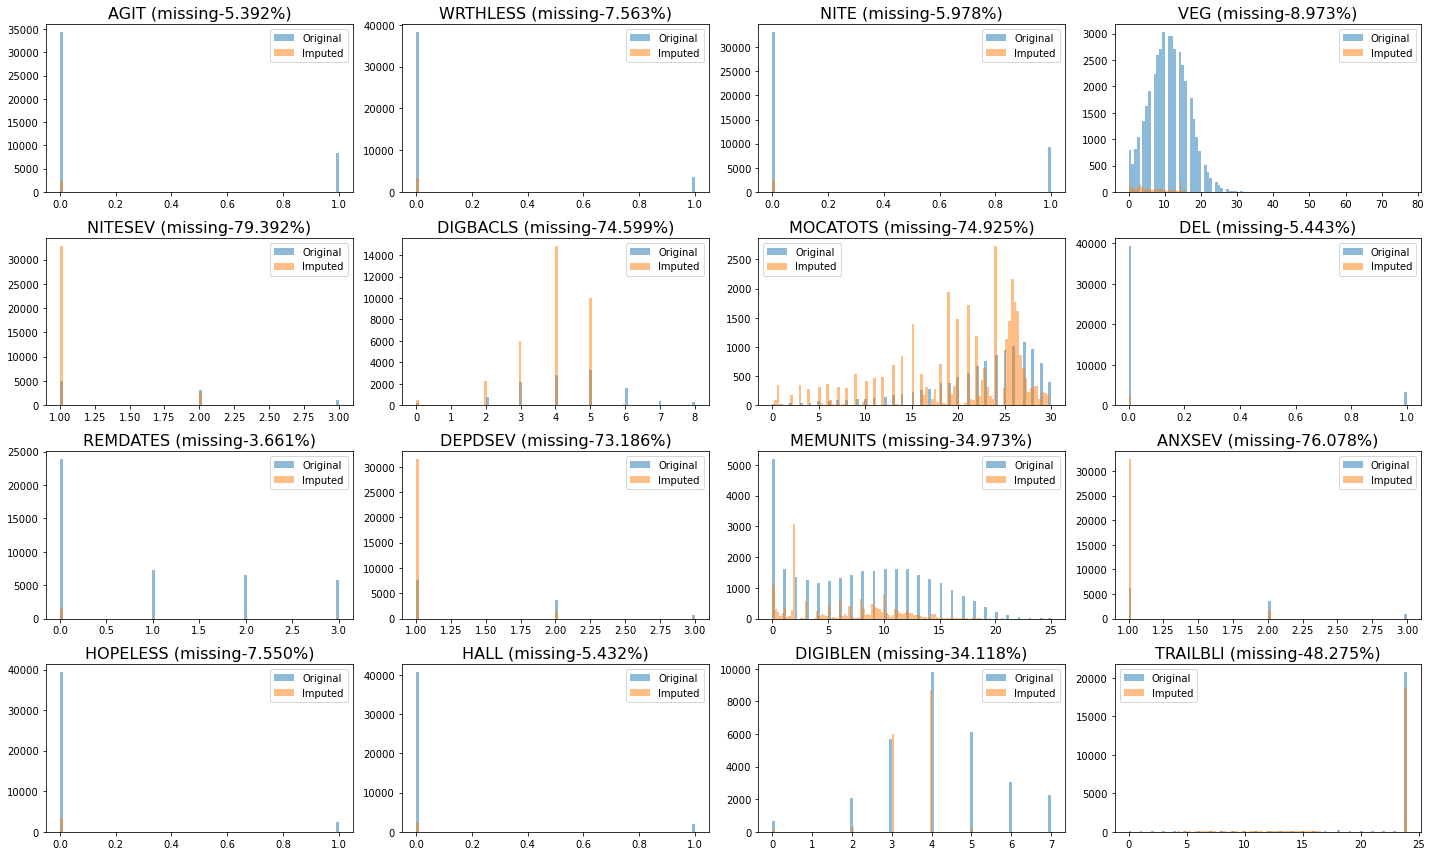

In [6]:
examine_missing_imputation(uds, uds_imputed, 16, 4, 4, (20, 12))

In [7]:
uds_rf = pd.concat([uds[['NACCID', 'NACCADC', 'NACCVNUM', 'datetime', 'SEX', 'NACCAGE','EDUC', 'NACCUDSD', 'NACCALZP']], 
                    uds_imputed], axis=1)
uds_rf.to_csv("../data/data_cleaned/uds_rf.csv", index = False)

## Impute MRI

In [8]:
mri = load_data.load_mri()
print("Original MRI shape:  ", mri.shape)

print("MRI features need to have missing rate below 85% and patients have missing features less than 95%")
mri = drop_missing(mri, row_thres=0.95, col_thres=0.85)
print("After dropping features:  ", mri.shape)

mri = mri.sort_values(['NACCID', 'datetime']).groupby("NACCID").first().reset_index() # Only keep the first record, 4.5k->2.8k
print("After dropping multiple measurements:  ", mri.shape)
print("Num of Features needs to be imputed:  ", (mri.isna().sum()>0).sum())

Original MRI shape:   (11273, 170)
MRI features need to have missing rate below 85% and patients have missing features less than 95%
After dropping features:   (4590, 158)
After dropping multiple measurements:   (2873, 158)
Num of Features needs to be imputed:   5


In [9]:
mri_to_fill = mri.drop(['NACCID', 'NACCVNUM', 'datetime'], axis=1)
mri_imputed = impute_missing_RF(mri_to_fill, small=1e-3)

Iteration 0: 1901184.791 (on NACCWMVL)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.99s/it]


Mean MSE: 16.605 (Largest-NACCICV: 54.528)
Iteration 1: 20272.557 (on NACCWMVL)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.16s/it]


Mean MSE: 16.605 (Largest-NACCICV: 54.528)
Iteration 2: 48.268 (on CSFVOL)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.04s/it]


Mean MSE: 16.606 (Largest-NACCICV: 54.528)
Iteration 3: 0.643 (on CSFVOL)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.99s/it]


Mean MSE: 16.606 (Largest-NACCICV: 54.528)
Iteration 4: 0.019 (on CSFVOL)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.99s/it]

Mean MSE: 16.606 (Largest-NACCICV: 54.528)
Finished-Iteration 5: 0.019 (on NACCWMVL)


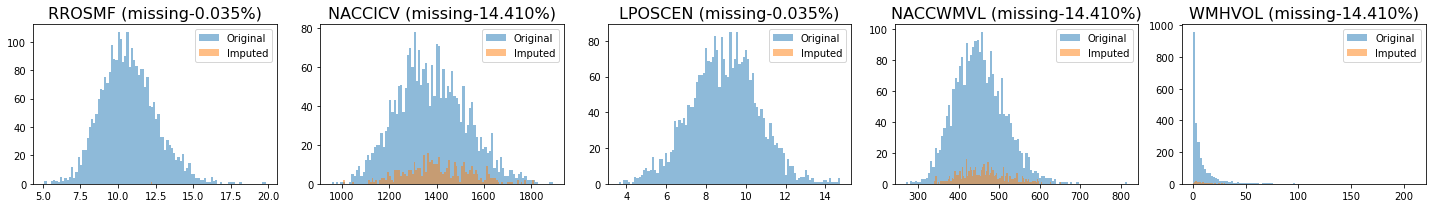

In [10]:
examine_missing_imputation(mri, mri_imputed, 5, 1, 5, (20, 3))

In [11]:
mri_rf = pd.concat([mri[['NACCID', 'NACCVNUM', 'datetime']], mri_imputed], axis=1)
mri_rf.to_csv("../data/data_cleaned/mri_rf.csv", index = False)

## Impute CSF

In [12]:
print("CSF features need to have missing rate below 80% and patients have missing less than 90%")
csf = load_data.load_csf()
print("Original CSF shape:  ", csf.shape)
csf = drop_missing(csf, row_thres=0.95, col_thres=0.85)
print("After dropping features:  ", csf.shape)

CSF features need to have missing rate below 80% and patients have missing less than 90%
Original CSF shape:   (3017, 23)
After dropping features:   (3017, 23)


In [13]:
csf_to_fill = csf.drop(['NACCID', 'NACCADC', 'CSFTTYR', 'CSFLPMO', 'CSFLPDY', 'CSFABMO', 'CSFABDY', 'CSFABYR',
                        'CSFPTMO', 'CSFPTDY', 'CSFPTYR', 'CSFTTMO', 'CSFTTDY', 'CSFTTYR', 'CSFLPYR',
                        'CSFTTMDX','CSFABMDX', 'CSFPTMDX'], axis=1)
csf_to_fill.head()

,CSFABETA,CSFPTAU,CSFTTAU,CSFABMD,CSFPTMD,CSFTTMD
0,491.0,NaN,388.0,1,NaN,1.0
1,614.4,38.6,32.2,2,2.0,2.0
2,365.0,NaN,793.0,1,NaN,1.0
3,274.0,NaN,255.0,1,NaN,1.0
4,348.4,84.1,49.9,2,2.0,2.0


In [14]:
all(csf_to_fill.iloc[:,:3].isna().to_numpy().flatten() == csf_to_fill.iloc[:,3:].isna().to_numpy().flatten())

False

In [15]:
# csf_to_fill = csf.drop(['NACCID', 'NACCADC', 'CSFTTYR', 'CSFLPMO', 'CSFLPDY', 'CSFABMO', 'CSFABDY', 'CSFABYR',
#                         'CSFPTMO', 'CSFPTDY', 'CSFPTYR', 'CSFTTMO', 'CSFTTDY', 'CSFTTYR', 'CSFLPYR',
#                         'CSFTTMDX','CSFABMDX', 'CSFPTMDX'], axis=1)
# csf_imputed = impute_missing_RF(csf_to_fill, small=1e-3)